In [2]:
import os
import numpy as np
import pickle
import torch
import seaborn as sns
import tempfile
import matplotlib.pyplot as plt
import copy

from molecule_featurizer import MoleculeFeaturizer
from rdkit import Chem
from ccdc.docking import Docker
from ccdc.io import MoleculeReader, EntryReader
from ccdc_rdkit_connector import CcdcRdkitConnector
from ccdc.descriptors import MolecularDescriptors
from torch_geometric.data import Batch
from litschnet import LitSchNet
from mol_viewer import MolViewer

In [3]:
data_dir = 'data/'
pdbbind_refined_dir = '../PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

In [4]:
with open(os.path.join(data_dir, 'random_splits', f'test_smiles_random_split_0.txt'), 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]
    
with open(os.path.join(data_dir, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    cel = pickle.load(f)

In [5]:
mol = cel.get_conf_ensemble('COc1ccc(-c2cn(C)c(=O)c3cc(C(=O)NC4CCS(=O)(=O)CC4)sc23)cc1OC').mol

In [6]:
mol.GetConformer(3).GetPropsAsDict()

{'PDB_ID': '4uiu', 'Generator': 'CCDC'}

In [7]:
# take smiles
# take one pdb for this smiles
# retrieve protein
# get generated confs for smiles
# do rigid docking with confs
# compare results

In [8]:
conf_dir='confs_for_gold/'

In [13]:
def rigid_docking(smiles, conf_dir='confs_for_gold/') :
    
    if not os.path.exists(conf_dir) :
        os.mkdir(conf_dir)

    ce = cel.get_conf_ensemble(smiles)
    pdb_id = ce.mol.GetConformer(0).GetProp('PDB_ID')
    generated_ids = [i for i, conf in enumerate(ce.mol.GetConformers()) if conf.HasProp('Generator')]

    if pdb_id in os.listdir(pdbbind_refined_dir) :
        protein_file = os.path.join(pdbbind_refined_dir, pdb_id, f'{pdb_id}_protein.pdb')
        ligand_file = os.path.join(pdbbind_refined_dir, pdb_id, f'{pdb_id}_ligand.mol2')
    else :
        protein_file = os.path.join(pdbbind_general_dir, pdb_id, f'{pdb_id}_protein.pdb')
        ligand_file = os.path.join(pdbbind_general_dir, pdb_id, f'{pdb_id}_ligand.mol2')

    connector = CcdcRdkitConnector()
    
    docker = Docker()
    settings = docker.settings
    
    settings.add_protein_file(protein_file)
    
    # Define binding site
    native_ligand = MoleculeReader(ligand_file)[0]
    protein = settings.proteins[0]
    settings.binding_site = settings.BindingSiteFromLigand(protein, native_ligand, 8.0)
    
    # Create generated conf files
    for conf_id in generated_ids :
        ccdc_mol = connector.rdkit_conf_to_ccdc_mol(ce.mol, conf_id=conf_id)
        #ccdc_mol.add_hydrogens()
        mol2_string = ccdc_mol.to_string(format='mol2')
        mol2_file_path = os.path.join(conf_dir, f'{conf_id}_{pdb_id}.mol2')
        with open(mol2_file_path, 'w') as writer :
            writer.write(mol2_string)
        settings.add_ligand_file(mol2_file_path, 1)

    # Set rigid ligand docking
    settings.fix_ligand_rotatable_bonds = 'all'

    settings.fitness_function = 'plp'
    settings.autoscale = 10.
    settings.early_termination = False

    batch_tempd = 'gold_docking'
    settings.output_directory = batch_tempd
    settings.output_file = 'docked_ligands.mol2'

    results = docker.dock()
    print(f'Return code: {results.return_code}')

#     batch_conf_file = settings.conf_file
#     print(batch_conf_file)

#     settings = Docker.Settings.from_file(batch_conf_file)
    results = Docker.Results(settings)
    ligands = results.ligands
    print(f'Number of poses: {len(ligands)}')

    ligand_scores = [l.fitness() for l in ligands]
    ligand_mols = [l.molecule for l in ligands]

    dummy_mol = copy.deepcopy(ce.mol)
    dummy_mol.RemoveAllConformers()
    dummy_mol.AddConformer(ce.mol.GetConformer(0), assignId=True)
    
#     print(np.array([[coord for coord in atom.coordinates] for atom in ligands[0].molecule.atoms]))
#     print(dummy_mol.GetConformer().GetPositions())
#     print(len([a for a in ligands[0].molecule.atoms if a.atomic_number > 1]))
#     print(dummy_mol.GetNumHeavyAtoms())
    
    new_confs_ids = connector.ccdc_conformers_to_rdkit_mol(ligands, dummy_mol)
    viewer = MolViewer()
    viewer.view(dummy_mol)
    
    encoder_path = os.path.join(data_dir, 'molecule_encoders.p')
    if os.path.exists(encoder_path) : # Load existing encoder
        with open(encoder_path, 'rb') as f:
            mol_encoders = pickle.load(f)
    mol_featurizer = MoleculeFeaturizer(mol_encoders)

    data_list = mol_featurizer.featurize_mol(dummy_mol)
    batch = Batch.from_data_list(data_list)

    experiment_name = f'random_split_0_new'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    litschnet.eval()

    with torch.no_grad() :
        preds = litschnet(batch).cpu().numpy()
    preds = preds.reshape(-1)
    
    ccdc_mol = connector.rdkit_conf_to_ccdc_mol(ce.mol, conf_id=0)
    gen_ccdc_mols = [connector.rdkit_conf_to_ccdc_mol(dummy_mol, i) for i in range(1, len(generated_ids) + 1)]
    real_rmsds = [MolecularDescriptors.rmsd(ccdc_mol, gen_ccdc_mol, overlay=True) for gen_ccdc_mol in gen_ccdc_mols]
    energies = [data.energy for data in data_list]

    sns.scatterplot(x=ligand_scores, y=preds[1:])
    plt.title('Score vs Pred')
    plt.show()

    print(real_rmsds)
    print(preds[1:])
    sns.scatterplot(x=real_rmsds, y=preds[1:])
    plt.title('RMSD vs Pred')
    plt.show()

    sns.scatterplot(x=real_rmsds, y=ligand_scores)
    plt.title('RMSD vs Score')
    plt.show()

    sns.scatterplot(x=real_rmsds, y=energies[1:])
    plt.title('RMSD vs Energy')
    plt.show()

    sns.scatterplot(x=preds[1:], y=energies[1:])
    plt.title('Pred vs Energy')
    plt.show()

Starting GOLD with conf file /home/benoit/bioactive_conformation_predictor/api_gold.conf
Setting up GOLD environment...
GOLD Version 2021.2.0
Running:
 
     "/home/benoit/CCDC/Discovery_2021/GOLD/gold/d_linux_64/bin/gold_linux_64" "/home/benoit/bioactive_conformation_predictor/api_gold.conf"

Return code: 0
Number of poses: 500


interactive(children=(IntSlider(value=0, description='conf_id', max=500), Output()), _dom_classes=('widget-int…

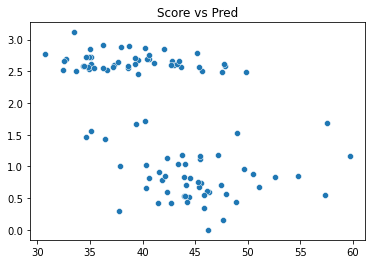

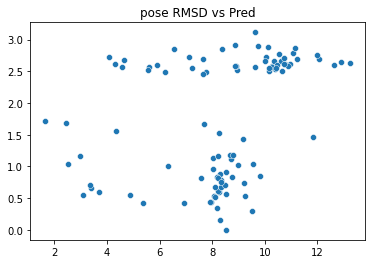

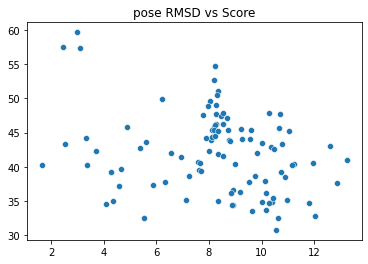

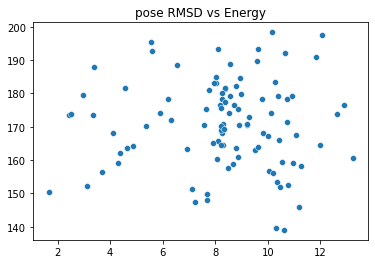

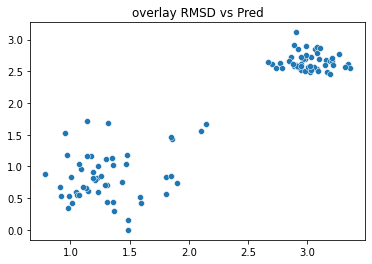

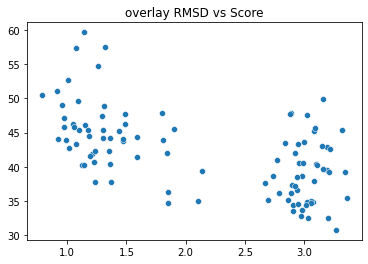

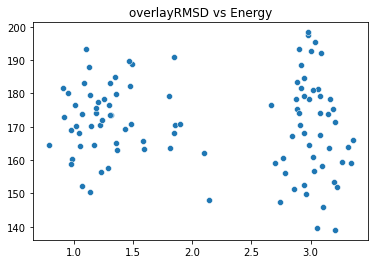

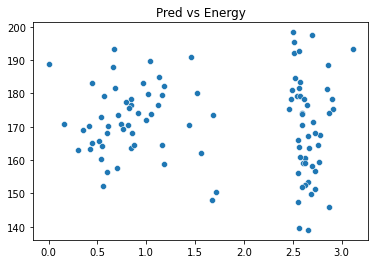

Starting GOLD with conf file /home/benoit/bioactive_conformation_predictor/api_gold.conf
Setting up GOLD environment...
GOLD Version 2021.2.0
Running:
 
     "/home/benoit/CCDC/Discovery_2021/GOLD/gold/d_linux_64/bin/gold_linux_64" "/home/benoit/bioactive_conformation_predictor/api_gold.conf"

Return code: 0
Number of poses: 500


interactive(children=(IntSlider(value=0, description='conf_id', max=500), Output()), _dom_classes=('widget-int…

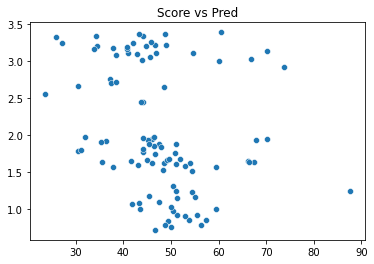

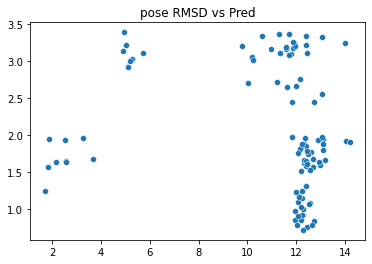

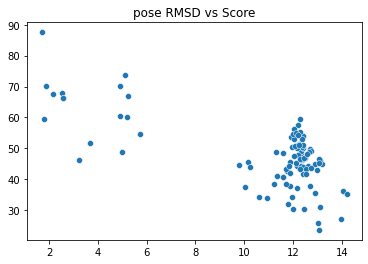

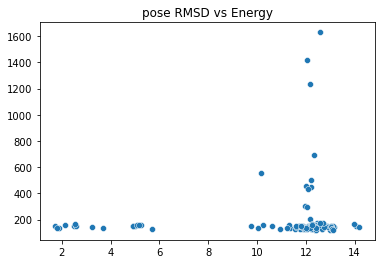

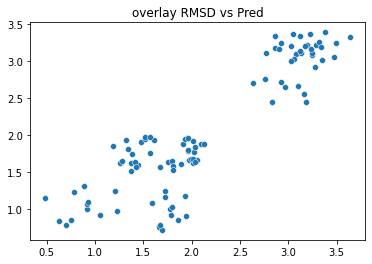

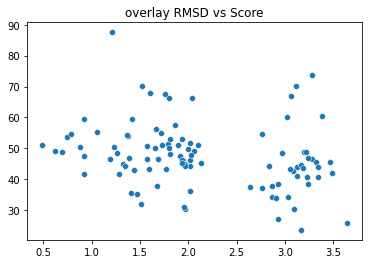

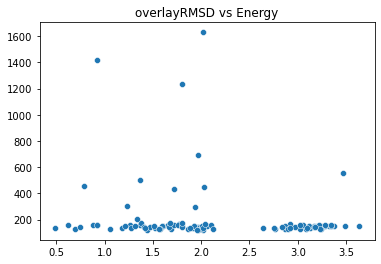

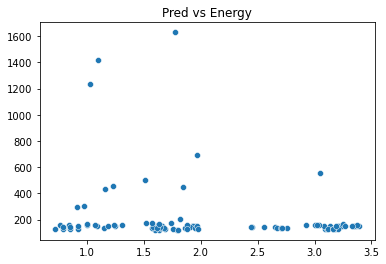

Starting GOLD with conf file /home/benoit/bioactive_conformation_predictor/api_gold.conf
Setting up GOLD environment...
GOLD Version 2021.2.0
Running:
 
     "/home/benoit/CCDC/Discovery_2021/GOLD/gold/d_linux_64/bin/gold_linux_64" "/home/benoit/bioactive_conformation_predictor/api_gold.conf"

Fatal error: 
Received interrupt [signal number 2]



KeyboardInterrupt: 

In [55]:
if not os.path.exists(conf_dir) :
    os.mkdir(conf_dir)
n_tries = 5
connector = CcdcRdkitConnector()
for smiles in test_smiles[:10] :
    
    try :
        ce = cel.get_conf_ensemble(smiles)
        pdb_id = ce.mol.GetConformer(0).GetProp('PDB_ID')
        generated_ids = [i for i, conf in enumerate(ce.mol.GetConformers()) if conf.HasProp('Generator')]
        n_generated_confs = len(generated_ids)

        if n_generated_confs == 100 :
        
            if pdb_id in os.listdir(pdbbind_refined_dir) :
                protein_file = os.path.join(pdbbind_refined_dir, pdb_id, f'{pdb_id}_protein.pdb')
                ligand_file = os.path.join(pdbbind_refined_dir, pdb_id, f'{pdb_id}_ligand.mol2')
            else :
                protein_file = os.path.join(pdbbind_general_dir, pdb_id, f'{pdb_id}_protein.pdb')
                ligand_file = os.path.join(pdbbind_general_dir, pdb_id, f'{pdb_id}_ligand.mol2')

            docker = Docker()
            settings = docker.settings

            settings.add_protein_file(protein_file)

            # Define binding site
            native_ligand = MoleculeReader(ligand_file)[0]
            protein = settings.proteins[0]
            settings.binding_site = settings.BindingSiteFromLigand(protein, native_ligand, 8.0)

            # Create generated conf files
            for conf_id in generated_ids :
                ccdc_mol = connector.rdkit_conf_to_ccdc_mol(ce.mol, conf_id=conf_id)
                #ccdc_mol.add_hydrogens()
                mol2_string = ccdc_mol.to_string(format='mol2')
                mol2_file_path = os.path.join(conf_dir, f'{conf_id}_{pdb_id}.mol2')
                with open(mol2_file_path, 'w') as writer :
                    writer.write(mol2_string)
                settings.add_ligand_file(mol2_file_path, n_tries)

            # Set rigid ligand docking
            settings.fix_ligand_rotatable_bonds = 'all'

            # params
            settings.fitness_function = 'plp'
            settings.autoscale = 10.
            settings.early_termination = False

            batch_tempd = 'gold_docking'
            settings.output_directory = batch_tempd
            settings.output_file = f'{pdb_id}_docked_ligands.mol2'

            results = docker.dock()
            print(f'Return code: {results.return_code}')

            results = Docker.Results(settings)
            ligands = results.ligands
            print(f'Number of poses: {len(ligands)}')

            ligand_scores = [l.fitness() for l in ligands]

            ligand_scores = np.array(ligand_scores).reshape(n_generated_confs, n_tries)
            best_pose_index = ligand_scores.argmax(1)
            ligand_scores = ligand_scores.max(1)
            
            reshaped_ligands = []
            current_l = []
            for l in ligands :
                current_l.append(l.molecule)
                if len(current_l) == n_tries :
                    reshaped_ligands.append(current_l)
                    current_l = []
            
            best_poses = [l[i] for l, i in zip(reshaped_ligands, best_pose_index)]
            for pose in best_poses :
                pose.remove_atoms([atom for atom in pose.atoms if atom.atomic_number == 0])
            
            dummy_mol = copy.deepcopy(ce.mol)
            dummy_mol.RemoveAllConformers()
            dummy_mol.AddConformer(ce.mol.GetConformer(0), assignId=True)

        #     print(np.array([[coord for coord in atom.coordinates] for atom in ligands[0].molecule.atoms]))
        #     print(dummy_mol.GetConformer().GetPositions())
        #     print(len([a for a in ligands[0].molecule.atoms if a.atomic_number > 1]))
        #     print(dummy_mol.GetNumHeavyAtoms())

            new_confs_ids = connector.ccdc_conformers_to_rdkit_mol(ligands, dummy_mol)
            viewer = MolViewer()
            viewer.view(dummy_mol)

            encoder_path = os.path.join(data_dir, 'molecule_encoders.p')
            if os.path.exists(encoder_path) : # Load existing encoder
                with open(encoder_path, 'rb') as f:
                    mol_encoders = pickle.load(f)
            mol_featurizer = MoleculeFeaturizer(mol_encoders)

            data_list = mol_featurizer.featurize_mol(dummy_mol)
            batch = Batch.from_data_list(data_list)

            experiment_name = f'random_split_0_new'
            if experiment_name in os.listdir('lightning_logs') :
                checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
                checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
                litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
            litschnet.eval()

            with torch.no_grad() :
                preds = litschnet(batch).cpu().numpy()
            preds = preds[1:].reshape(n_generated_confs, n_tries)
            preds = preds[np.arange(preds.shape[0]), best_pose_index]

            ccdc_mol = connector.rdkit_conf_to_ccdc_mol(ce.mol, conf_id=0)
            real_overlay_rmsds = np.array([MolecularDescriptors.rmsd(ccdc_mol, pose, overlay=True) for pose in best_poses])
            pose_rmsds = np.array([MolecularDescriptors.rmsd(ccdc_mol, pose, overlay=False) for pose in best_poses])
            energies = np.array([data.energy for data in data_list][1:]).reshape(n_generated_confs, n_tries)
            energies = energies[np.arange(preds.shape[0]), best_pose_index]

            sns.scatterplot(x=ligand_scores, y=preds)
            plt.title('Score vs Pred')
            plt.show()

            sns.scatterplot(x=pose_rmsds, y=preds)
            plt.title('pose RMSD vs Pred')
            plt.show()

            sns.scatterplot(x=pose_rmsds, y=ligand_scores)
            plt.title('pose RMSD vs Score')
            plt.show()

            sns.scatterplot(x=pose_rmsds, y=energies)
            plt.title('pose RMSD vs Energy')
            plt.show()
            
            sns.scatterplot(x=real_overlay_rmsds, y=preds)
            plt.title('overlay RMSD vs Pred')
            plt.show()

            sns.scatterplot(x=real_overlay_rmsds, y=ligand_scores)
            plt.title('overlay RMSD vs Score')
            plt.show()

            sns.scatterplot(x=real_overlay_rmsds, y=energies)
            plt.title('overlayRMSD vs Energy')
            plt.show()

            sns.scatterplot(x=preds, y=energies)
            plt.title('Pred vs Energy')
            plt.show()
    except Exception as e:
        print('Error ' + str(e))

In [50]:
with torch.no_grad() :
    preds = litschnet(batch).cpu().numpy()
preds = preds[1:].reshape(n_generated_confs, n_tries)

In [40]:
ligand_scores

array([37.0604, 24.6882, 28.0504])

In [52]:
preds

array([[0.552639  , 0.5527954 , 0.5525422 , 0.55247015, 0.5525665 ],
       [0.6234013 , 0.6236594 , 0.62341213, 0.62327594, 0.62303793],
       [0.6521321 , 0.6521327 , 0.65188646, 0.6518508 , 0.6518467 ]],
      dtype=float32)

In [51]:
preds[np.arange(preds.shape[0]), best_pose_index]

array([0.552639 , 0.6234013, 0.6521321], dtype=float32)

In [33]:
ccdc_mol.atoms

[Atom(C1),
 Atom(C2),
 Atom(C3),
 Atom(N4),
 Atom(C5),
 Atom(N6),
 Atom(C7),
 Atom(C8),
 Atom(N9),
 Atom(N10),
 Atom(C11),
 Atom(C12),
 Atom(C13),
 Atom(N14),
 Atom(C15)]

In [35]:
[atom.atomic_number for atom in best_poses[0].atoms]

[6, 6, 6, 7, 6, 7, 6, 6, 7, 7, 6, 6, 6, 7, 6, 0, 0, 0, 0]

In [18]:
energies

array([[476.71453585, 503.83245576, 475.22000052, 475.13620703,
        482.09722016],
       [486.8262675 , 489.67732514, 482.64615064, 478.64219342,
        479.28510824],
       [546.53476923, 487.39814175, 487.5323737 , 484.8520556 ,
        494.62871154],
       [533.38981009, 525.26689624, 476.13843892, 476.1291245 ,
        507.17116177],
       [483.29952192, 487.20968426, 477.54488767, 479.75709135,
        480.68132328],
       [488.20001409, 477.77518437, 477.75425997, 477.67599202,
        487.64529032],
       [546.71351541, 484.839236  , 503.40549438, 544.70010479,
        590.76174378],
       [469.71914673, 473.23157762, 473.34156536, 647.09067898,
        610.40212375],
       [481.98185832, 482.00339591, 489.03566825, 489.03566825,
        489.98804785],
       [532.75602956, 557.08203902, 530.44440062, 530.32963904,
        541.25973827],
       [531.35741537, 546.58105303, 541.82241061, 541.85247144,
        544.40810765],
       [478.20432363, 478.06327282, 492.248

In [30]:
docker = Docker()
settings = docker.settings

In [32]:
settings.proteins

()

In [29]:
ligand_scores

[25.1584, 16.6961, 42.2535]

In [58]:
settings = Docker.Settings.from_file(batch_conf_file)
results = Docker.Results(settings)
ligands = results.ligands
print(f'Number of poses: {len(ligands)}')

Number of poses: 10


In [59]:
ls = [l for l in ligands]

In [60]:
ls[0].fitness()

52.1082

In [55]:
ligand_scores = [l.fitness() for l in ligands]

RuntimeError: No fitness term in the entry

Starting GOLD with conf file /home/benoit/bioactive_conformation_predictor/api_gold.conf
Setting up GOLD environment...
GOLD Version 2021.2.0
Running:
 
     "/home/benoit/CCDC/Discovery_2021/GOLD/gold/d_linux_64/bin/gold_linux_64" "/home/benoit/bioactive_conformation_predictor/api_gold.conf"

Return code: 0
Number of poses: 10


interactive(children=(IntSlider(value=0, description='conf_id', max=10), Output()), _dom_classes=('widget-inte…

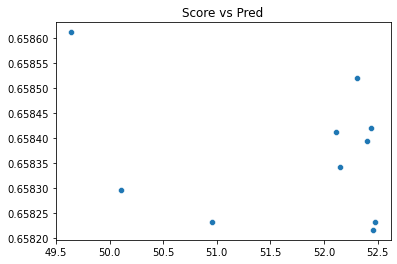

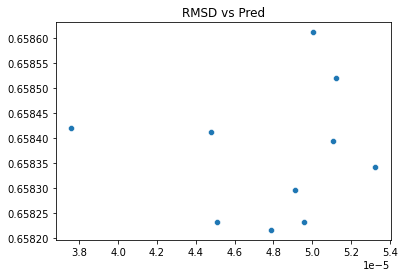

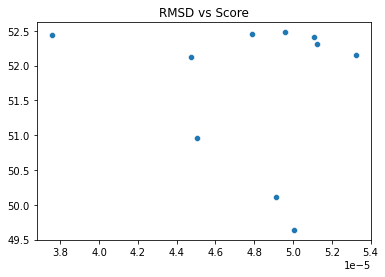

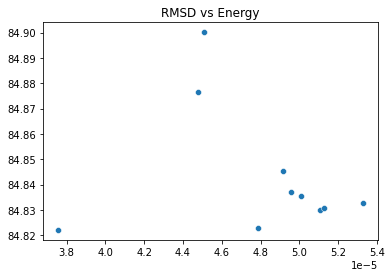

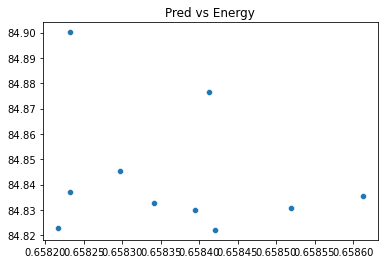

Starting GOLD with conf file /home/benoit/bioactive_conformation_predictor/api_gold.conf
Setting up GOLD environment...
GOLD Version 2021.2.0
Running:
 
     "/home/benoit/CCDC/Discovery_2021/GOLD/gold/d_linux_64/bin/gold_linux_64" "/home/benoit/bioactive_conformation_predictor/api_gold.conf"

Return code: 0
Number of poses: 10


interactive(children=(IntSlider(value=0, description='conf_id', max=10), Output()), _dom_classes=('widget-inte…

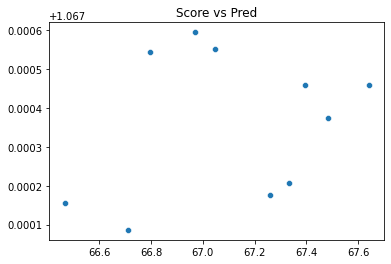

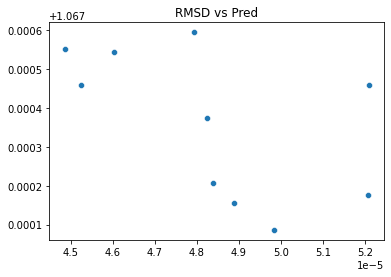

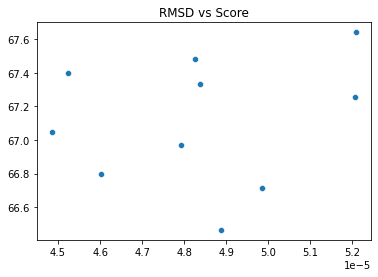

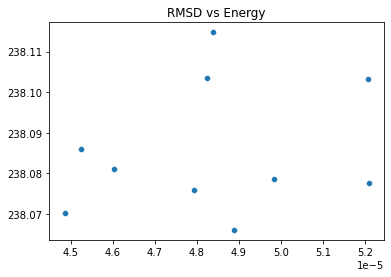

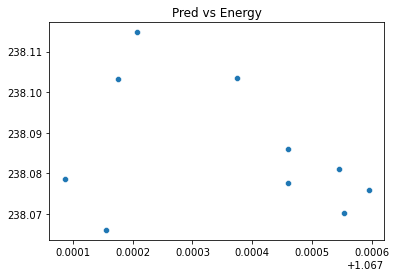

Starting GOLD with conf file /home/benoit/bioactive_conformation_predictor/api_gold.conf
Setting up GOLD environment...
GOLD Version 2021.2.0
Running:
 
     "/home/benoit/CCDC/Discovery_2021/GOLD/gold/d_linux_64/bin/gold_linux_64" "/home/benoit/bioactive_conformation_predictor/api_gold.conf"

Return code: 0
Number of poses: 10


interactive(children=(IntSlider(value=0, description='conf_id', max=10), Output()), _dom_classes=('widget-inte…

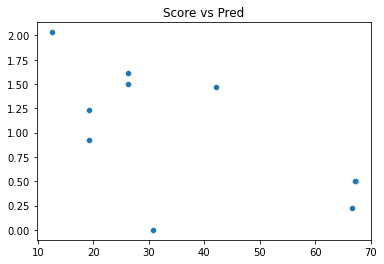

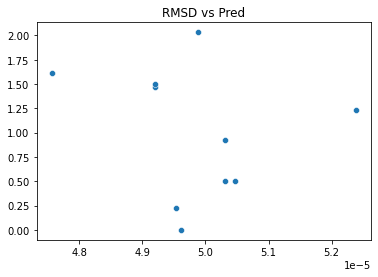

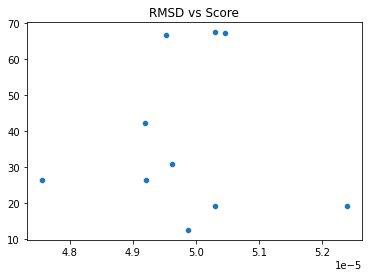

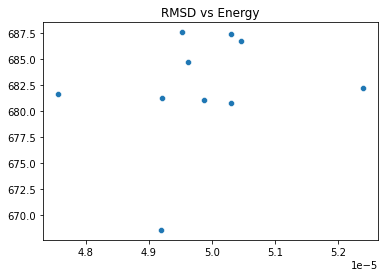

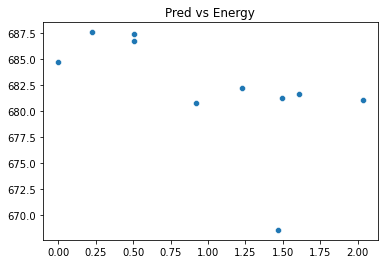

Starting GOLD with conf file /home/benoit/bioactive_conformation_predictor/api_gold.conf
Setting up GOLD environment...
GOLD Version 2021.2.0
Running:
 
     "/home/benoit/CCDC/Discovery_2021/GOLD/gold/d_linux_64/bin/gold_linux_64" "/home/benoit/bioactive_conformation_predictor/api_gold.conf"

Return code: 0
Number of poses: 10


interactive(children=(IntSlider(value=0, description='conf_id', max=10), Output()), _dom_classes=('widget-inte…

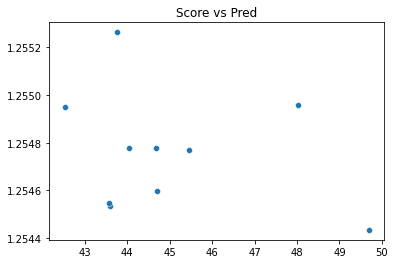

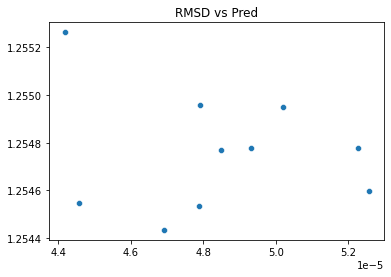

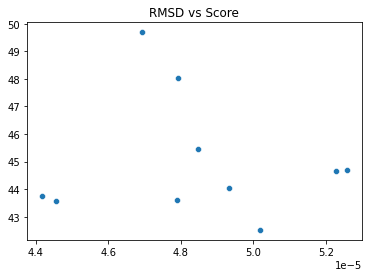

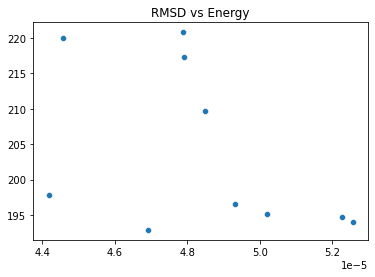

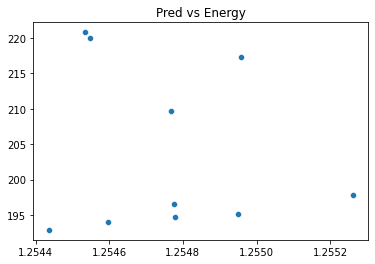

Starting GOLD with conf file /home/benoit/bioactive_conformation_predictor/api_gold.conf
Setting up GOLD environment...
GOLD Version 2021.2.0
Running:
 
     "/home/benoit/CCDC/Discovery_2021/GOLD/gold/d_linux_64/bin/gold_linux_64" "/home/benoit/bioactive_conformation_predictor/api_gold.conf"

Return code: 0
Number of poses: 10


interactive(children=(IntSlider(value=0, description='conf_id', max=10), Output()), _dom_classes=('widget-inte…

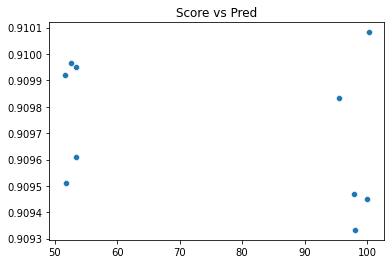

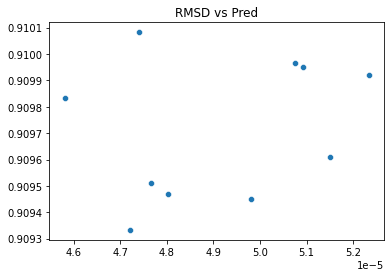

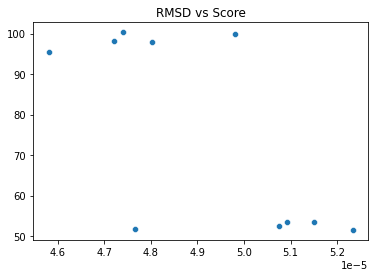

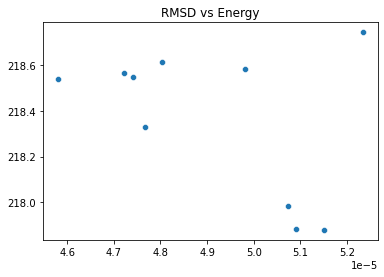

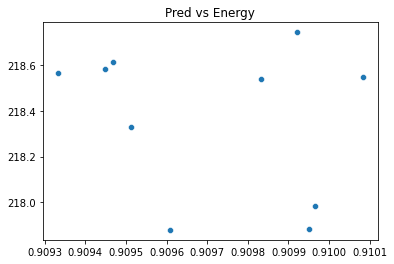

In [5]:
for smiles in test_smiles[:5] :
    try :
        ce = cel.get_conf_ensemble(smiles)
        pdb_id = ce.mol.GetConformer().GetProp('PDB_ID')
        generated_ids = [i for i, conf in enumerate(ce.mol.GetConformers()) if conf.HasProp('Generator')]
        
        if pdb_id in os.listdir(pdbbind_refined_dir) :
            protein_file = os.path.join(pdbbind_refined_dir, pdb_id, f'{pdb_id}_protein.pdb')
        else :
            protein_file = os.path.join(pdbbind_general_dir, pdb_id, f'{pdb_id}_protein.pdb')

        rdkit_mol = Chem.MolFromMol2File(ligand_file)

        with Chem.SDWriter('temp.sdf') as writer :
            for conf_id in generated_ids :
                writer.write(rdkit_mol, confId=conf_id)
        connector = CcdcRdkitConnector()
        ccdc_mol = connector.rdkit_conf_to_ccdc_mol(rdkit_mol=rdkit_mol)

        docker = Docker()
        settings = docker.settings
        # Set rigid ligand docking
        settings.fix_ligand_rotatable_bonds = 'all'
        
        settings.add_protein_file(protein_file)

        native_ligand = MoleculeReader(ligand_file)[0]
        protein = settings.proteins[0]
        settings.binding_site = settings.BindingSiteFromLigand(protein, native_ligand, 8.0)

        settings.fitness_function = 'plp'
        settings.autoscale = 10.
        settings.early_termination = False

        batch_tempd = tempfile.mkdtemp()
        settings.output_directory = batch_tempd
        settings.output_file = 'docked_ligands.mol2'

        ligand = MoleculeReader(ligand_file)[0]
        settings.add_ligand_file(ligand_file, 10)

        results = docker.dock()

        print(f'Return code: {results.return_code}')

        batch_conf_file = settings.conf_file

        settings = Docker.Settings.from_file(batch_conf_file)
        results = Docker.Results(settings)
        ligands = results.ligands
        print(f'Number of poses: {len(ligands)}')

        ligand_scores = [l.fitness() for l in ligands]
        ligand_mols = [l.molecule for l in ligands]

        new_confs_ids = connector.ccdc_conformers_to_rdkit_mol(ligands, rdkit_mol)

        viewer = MolViewer()
        viewer.view(rdkit_mol)

        encoder_path = os.path.join(data_dir, 'molecule_encoders.p')
        if os.path.exists(encoder_path) : # Load existing encoder
            with open(encoder_path, 'rb') as f:
                mol_encoders = pickle.load(f)
        mol_featurizer = MoleculeFeaturizer(mol_encoders)

        ids = [conf.GetId() for conf in rdkit_mol.GetConformers()]
        data_list = mol_featurizer.featurize_mol(rdkit_mol)
        batch = Batch.from_data_list(data_list)

        experiment_name = f'random_split_0_new'
        if experiment_name in os.listdir('lightning_logs') :
            checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
            checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
            litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
        litschnet.eval()
        
        with torch.no_grad() :
            preds = litschnet(batch).cpu().numpy()
        preds = preds.reshape(-1)
        
        gen_ccdc_mols = [connector.rdkit_conf_to_ccdc_mol(rdkit_mol, i) for i in range(1, 11)]
        real_rmsds = [MolecularDescriptors.rmsd(ccdc_mol, gen_ccdc_mol, overlay=True) for gen_ccdc_mol in gen_ccdc_mols]
        energies = [data.energy for data in data_list]
        
        sns.scatterplot(x=ligand_scores, y=preds[1:])
        plt.title('Score vs Pred')
        plt.show()
        
        sns.scatterplot(x=real_rmsds, y=preds[1:])
        plt.title('RMSD vs Pred')
        plt.show()
        
        sns.scatterplot(x=real_rmsds, y=ligand_scores)
        plt.title('RMSD vs Score')
        plt.show()
        
        sns.scatterplot(x=real_rmsds, y=energies[1:])
        plt.title('RMSD vs Energy')
        plt.show()
        
        sns.scatterplot(x=preds[1:], y=energies[1:])
        plt.title('Pred vs Energy')
        plt.show()
        
    except Exception as e:
        print(f'{smiles} not found, {e}')

In [5]:
batch

DataBatch(edge_index=[2, 7272], pos=[3333, 3], z=[3333], data_id=[101], mmff_energy=[101], batch=[3333], ptr=[102])

100


/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:14: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning


interactive(children=(IntSlider(value=0, description='conf_id'), Output()), _dom_classes=('widget-interact',))

LitSchNet(
  (schnet): SchNet(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10.0)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)

<AxesSubplot:>

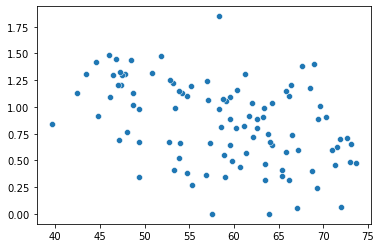

<AxesSubplot:>

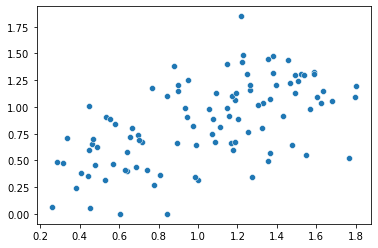

<AxesSubplot:>

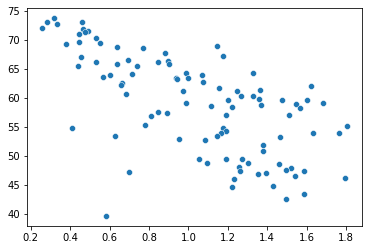

In [15]:
ligands = results.ligands

In [16]:
first_dock = ligands[0]
'Gold.PLP.Fitness' in first_dock.attributes

True

In [17]:
'Gold.PLP.part.hbond' in first_dock.attributes

True

In [18]:
'Gold.PLP.part.buried' in first_dock.attributes

True

In [19]:
print(first_dock.fitness()) 

55.8614


In [20]:
print(first_dock.fitness('plp')) 

55.8614


In [21]:
print(first_dock.fitness(settings.fitness_function))

55.8614


In [22]:
print(first_dock.scoring_term())

{'Gold.PLP.Chemscore.CHOScore': 0.0, 'Gold.PLP.Chemscore.Hbond': 7.3219, 'Gold.PLP.Chemscore.Internal.Correction': 0.0813, 'Gold.PLP.Chemscore.Metal': 0.0, 'Gold.PLP.Fitness': 55.8614, 'Gold.PLP.PLP': -34.9056, 'Gold.PLP.ligand.clash': 0.0, 'Gold.PLP.ligand.torsion': 0.5456, 'Gold.PLP.part.buried': -8.7825, 'Gold.PLP.part.hbond': -7.2443, 'Gold.PLP.part.metal': 0.0, 'Gold.PLP.part.nonpolar': -27.9584, 'Gold.PLP.part.repulsive': 8.3367}


In [23]:
print(first_dock.scoring_term('plp', 'chemscore', 'hbond'))

7.3219


In [24]:
print(first_dock.hbonds())

(HBond(Atom(N2)-Atom(H9)-Atom(OD1)), HBond(Atom(N)-Atom(H)-Atom(OE1)), HBond(Atom(N)-Atom(H)-Atom(OE1)), HBond(Atom(N)-Atom(H)-Atom(O7)), HBond(Atom(NE)-Atom(HE)-Atom(O)), HBond(Atom(ND2)-Atom(1HD2)-Atom(O)), HBond(Atom(N)-Atom(H)-Atom(OE2)))


In [25]:
protein = results.make_complex(ligands[0])

In [26]:
print(len(protein.ligands))

1
